In [2]:
import pandas as pd
import numpy as np
import re

from sklearn.cluster import DBSCAN, KMeans
from sklearn.neighbors import KernelDensity
from sklearn.preprocessing import LabelEncoder, StandardScaler, OneHotEncoder
from sklearn.metrics import silhouette_score

# import kmeans1d
'''
kmeans1d

A Python library with an implementation of k-means clustering on 1D data, based on the algorithm in (Xiaolin 1991), as presented in section 2.2 of (Gronlund et al., 2017).

Globally optimal k-means clustering is NP-hard for multi-dimensional data. Lloyd's algorithm is a popular approach for finding a locally optimal solution. For 1-dimensional data, there are polynomial time algorithms. The algorithm implemented here is a O(kn + n log n) dynamic programming algorithm for finding the globally optimal k clusters for n 1D data points.

The code is written in C++, and wrapped with Python.
'''

# import seaborn as sns

import matplotlib.pyplot as plt
%matplotlib inline


In [3]:
# shape (381109, 11)
# data_1 = pd.read_csv('datasets/d1.csv')
# data_1 = data_1.drop(['id'], axis=1)
data_1 = pd.read_csv('datasets/d1_bootstraped.csv')

data_2 = pd.read_csv('datasets/d2.csv')


In [4]:
data_1


,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage,Response
0,Female,46,1,28.0,1,1-2 Year,No,2630.0,124.0,255,0
1,Male,60,1,28.0,0,1-2 Year,Yes,40770.0,26.0,77,0
2,Male,59,1,48.0,0,> 2 Years,Yes,2630.0,124.0,30,0
3,Female,24,1,33.0,1,< 1 Year,No,29419.0,152.0,82,0
4,Male,22,1,18.0,1,< 1 Year,No,26714.0,152.0,156,0
...,...,...,...,...,...,...,...,...,...,...,...
93415,Female,43,1,28.0,0,1-2 Year,Yes,42013.0,125.0,199,1
93416,Female,30,1,8.0,0,< 1 Year,Yes,41314.0,124.0,128,1
93417,Male,40,1,13.0,0,1-2 Year,Yes,34503.0,26.0,163,1
93418,Male,58,1,28.0,0,> 2 Years,Yes,51016.0,26.0,164,1


In [5]:
data_1.nunique()


Gender                      2
Age                        66
Driving_License             2
Region_Code                53
Previously_Insured          2
Vehicle_Age                 3
Vehicle_Damage              2
Annual_Premium          32550
Policy_Sales_Channel      135
Vintage                   290
Response                    2
dtype: int64

0    56
1    44
Name: Response, dtype: int64

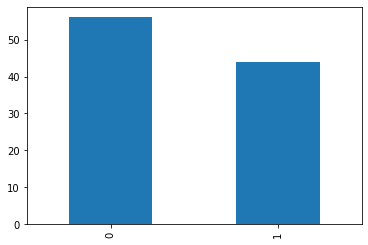

In [6]:
data_1 = data_1.sample(100)

data_1['Response'].value_counts().plot(kind='bar')
data_1['Response'].value_counts()


In [7]:
data_1.head()


,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage,Response
2728,Male,27,1,18.0,0,< 1 Year,No,24888.0,124.0,255,0
75739,Female,64,1,0.0,0,1-2 Year,Yes,2630.0,124.0,203,1
15039,Female,37,1,32.0,1,1-2 Year,No,34199.0,138.0,152,0
8771,Female,23,1,6.0,1,< 1 Year,No,23156.0,152.0,291,0
90649,Female,43,1,28.0,0,1-2 Year,Yes,2630.0,124.0,38,1


In [8]:
top_n = 10
likely_dis = []

# check if attribute is continuous or discrete dataframe
for var in data_1.columns:
    # Find the ratio of number of unique values to the total number of unique values. Something like the following
    # if 1.*data_1[var].nunique()/data_1[var].count() > 0.5:

    # Check if the top n unique values account for more than a certain proportion of all values
    if 1.*data_1[var].value_counts(normalize=True).head(top_n).sum() < 0.5:
        likely_dis.append(var)

likely_dis


['Age', 'Annual_Premium', 'Vintage']

In [9]:
from itertools import combinations
columns_name = set(data_1.columns).difference(likely_dis)
columns_name.remove('Response')
combX = []
comb_max_depth = 3
for idx, _ in enumerate(columns_name):
    if comb_max_depth and comb_max_depth == idx:
        break
    combX.extend(list(combinations(columns_name, idx + 1)))

combX = sorted(combX, key=len)
combX


[('Vehicle_Age',),
 ('Gender',),
 ('Vehicle_Damage',),
 ('Previously_Insured',),
 ('Policy_Sales_Channel',),
 ('Region_Code',),
 ('Driving_License',),
 ('Vehicle_Age', 'Gender'),
 ('Vehicle_Age', 'Vehicle_Damage'),
 ('Vehicle_Age', 'Previously_Insured'),
 ('Vehicle_Age', 'Policy_Sales_Channel'),
 ('Vehicle_Age', 'Region_Code'),
 ('Vehicle_Age', 'Driving_License'),
 ('Gender', 'Vehicle_Damage'),
 ('Gender', 'Previously_Insured'),
 ('Gender', 'Policy_Sales_Channel'),
 ('Gender', 'Region_Code'),
 ('Gender', 'Driving_License'),
 ('Vehicle_Damage', 'Previously_Insured'),
 ('Vehicle_Damage', 'Policy_Sales_Channel'),
 ('Vehicle_Damage', 'Region_Code'),
 ('Vehicle_Damage', 'Driving_License'),
 ('Previously_Insured', 'Policy_Sales_Channel'),
 ('Previously_Insured', 'Region_Code'),
 ('Previously_Insured', 'Driving_License'),
 ('Policy_Sales_Channel', 'Region_Code'),
 ('Policy_Sales_Channel', 'Driving_License'),
 ('Region_Code', 'Driving_License'),
 ('Vehicle_Age', 'Gender', 'Vehicle_Damage'),
 (

In [10]:
# Scaleing is a process of transforming data into a stander values so we can get the best of it
#
# https://stats.stackexchange.com/questions/89809/is-it-important-to-scale-data-before-clustering
scaler = StandardScaler()
scaled_column_names = [x for x in likely_dis if x.lower() not in ['id']]
data_cluster = data_1[scaled_column_names].copy()
scaled_data = scaler.fit_transform(data_cluster)

data_scaled = data_1.copy()
data_scaled[scaled_column_names] = scaled_data
data_scaled

# [['Vintage','Annual_Premium']]
# scaler.inverse_transform([[0.748795	, 0.574539]])


,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage,Response
2728,Male,-0.948938,1,18.0,0,< 1 Year,No,-0.212608,124.0,1.133009,0
75739,Female,1.610151,1,0.0,0,1-2 Year,Yes,-1.501982,124.0,0.511855,1
15039,Female,-0.257292,1,32.0,1,1-2 Year,No,0.326765,138.0,-0.097354,0
8771,Female,-1.225596,1,6.0,1,< 1 Year,No,-0.312940,152.0,1.563038,0
90649,Female,0.157695,1,28.0,0,1-2 Year,Yes,-1.501982,124.0,-1.459115,1
...,...,...,...,...,...,...,...,...,...,...,...
46283,Male,-1.294761,1,12.0,0,< 1 Year,Yes,-1.501982,152.0,-1.674129,0
46182,Male,-1.225596,1,30.0,1,< 1 Year,No,-0.063326,152.0,-0.622946,0
39569,Female,-1.433090,1,36.0,1,< 1 Year,Yes,2.146592,160.0,0.882158,0
45888,Female,-0.948938,1,28.0,1,< 1 Year,No,0.217686,152.0,0.368512,0


In [11]:
from scipy import stats
data_scaled = data_scaled[(
    np.abs(stats.zscore(data_scaled.Annual_Premium)) < 3)]
data_scaled


,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage,Response
2728,Male,-0.948938,1,18.0,0,< 1 Year,No,-0.212608,124.0,1.133009,0
75739,Female,1.610151,1,0.0,0,1-2 Year,Yes,-1.501982,124.0,0.511855,1
15039,Female,-0.257292,1,32.0,1,1-2 Year,No,0.326765,138.0,-0.097354,0
8771,Female,-1.225596,1,6.0,1,< 1 Year,No,-0.312940,152.0,1.563038,0
90649,Female,0.157695,1,28.0,0,1-2 Year,Yes,-1.501982,124.0,-1.459115,1
...,...,...,...,...,...,...,...,...,...,...,...
46283,Male,-1.294761,1,12.0,0,< 1 Year,Yes,-1.501982,152.0,-1.674129,0
46182,Male,-1.225596,1,30.0,1,< 1 Year,No,-0.063326,152.0,-0.622946,0
39569,Female,-1.433090,1,36.0,1,< 1 Year,Yes,2.146592,160.0,0.882158,0
45888,Female,-0.948938,1,28.0,1,< 1 Year,No,0.217686,152.0,0.368512,0


In [12]:
le = LabelEncoder()
encoder_dict = dict()
data_endocded = data_scaled.copy()

for col in data_endocded:
    if col not in ['Annual_Premium', 'Vintage']:
        le = le.fit(data_endocded[col])
        data_endocded[col] = le.transform(data_endocded[col])
        encoder_dict[col] = le

np.save('encoder_dict.npy', encoder_dict)
# encoder_dict = np.load('encoder_dict.npy', allow_pickle=True).tolist()
data_endocded.to_csv('data_endocded.csv', index=False)
data_endocded = pd.read_csv('data_endocded.csv')
data_endocded.head()


,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage,Response
0,1,7,0,11,0,1,0,-0.212608,7,1.133009,0
1,0,40,0,0,0,0,1,-1.501982,7,0.511855,1
2,0,17,0,18,1,0,0,0.326765,8,-0.097354,0
3,0,3,0,3,1,1,0,-0.312940,9,1.563038,0
4,0,23,0,16,0,0,1,-1.501982,7,-1.459115,1


In [48]:
class RST:
    def __init__(
        self,
        data: pd.DataFrame = None,
        continuous_columns: list = [],
        decision_column_name: str = 'class',
    ):

        # Primary variable of RST class
        self._data = data
        self.continuous_columns = continuous_columns
        self.decision_column_name = decision_column_name
        self.data = self._data[set(self._data.columns).difference(
            self.continuous_columns)]
        self.data_indiscernibility = {}
        self.unique_indiscernibility = []
        self.reduct_combination = []
        self.lower_approx = {}
        self.upper_approx = {}
        self.boundary_region = {}
        self.outside_region = {}
        self.U = self._list_to_set_conversion(self.data.index.values.tolist())

        # Config Variable
        self.target_unique = self.data[decision_column_name].unique()
        self.target_sets = self.get_indiscernibility([decision_column_name])[0]
        self.target_sets_dict = {self.target_unique[idx]: ele for idx, ele in enumerate(
            self.target_sets[decision_column_name])}

    def get_indiscernibility(self, combination: list = []):

        def indices(lst, item):
            return [i for i, x in enumerate(lst) if x == item]

        selected_columns = self.data[combination].to_dict('list')
        data = list(zip(*selected_columns.values()))

        print(data)
        if list(indices(data, x) for x in set(data) if data.count(x) > 0) in self.unique_indiscernibility:
            self.reduct_combination.append(self._create_names(combination))
        else:
            self.unique_indiscernibility.append(
                list(indices(data, x) for x in set(data) if data.count(x) > 0))

            self.data_indiscernibility.update({
                self._create_names(combination): list(indices(data, x) for x in set(data) if data.count(x) > 0)
            })

        return [self.data_indiscernibility, self.reduct_combination]

    def set_main_variable(self, combination: list = []):
        _c_n = self._create_names(combination)  # combination name

        if _c_n not in self.data_indiscernibility:
            self.get_indiscernibility(combination)

        if _c_n in self.reduct_combination:
            return [{}, {}, {}, {}]
        
        combination.append(self.decision_column_name)
        combination_upper = {}
        combination_lower = {}

        for target, set in self.target_sets_dict.items():
            c = combination.copy()
            c.append(str(target))
            __c_n = self._create_names(c)

            self.lower_approx.update({__c_n: []})
            self.upper_approx.update({__c_n: []})
            self.boundary_region.update({__c_n: []})
            self.outside_region.update({__c_n: []})

            for IND in self.data_indiscernibility[_c_n]:
                if all(True if x in set else False for x in IND):
                    self.lower_approx[__c_n].extend(IND)

                if any(True if x in set else False for x in IND):
                    self.upper_approx[__c_n].extend(IND)

            combination_lower.update({__c_n: self.lower_approx[__c_n]})
            combination_upper.update({__c_n: self.upper_approx[__c_n]})

            upper = self._list_to_set_conversion(self.upper_approx[__c_n])
            lower = self._list_to_set_conversion(self.lower_approx[__c_n])

            self.boundary_region[__c_n].extend(upper - lower)
            self.outside_region[__c_n].extend(self.U - upper)
        return [
            combination_upper,
            combination_lower,
            self.boundary_region[__c_n],
            self.outside_region[__c_n]
        ]

    def get_dependency(self, combination: list = []):
        _, lower, _, _ = self.set_main_variable(combination)
        divider = sum([len(v) for v in lower.values()])
        dependency = divider / len(self.U)
        return [
            lower,
            dependency
        ]

    def _create_names(self, e) -> str:
        return '|'.join(e)

    def _list_to_set_conversion(self, l):
        se = set()
        for x in l:
            se.add(x)
        return se


In [49]:
test = pd.read_csv('test.csv')
rst = RST(test, decision_column_name='class')
lower, dependency = rst.get_dependency(combination=list({'s1', 'p1'}))
lower, dependency

[(0,), (1,), (1,), (0,), (0,), (1,), (1,), (0,)]
[(1, 1), (2, 1), (3, 1), (1, 0), (2, 0), (3, 0), (2, 0), (3, 0)]
{'class': [[0, 3, 4, 7], [1, 2, 5, 6]], 'p1|s1': [[1], [2], [0], [4, 6], [5, 7], [3]]}


C:\Users\ahmad\AppData\Local\Temp\ipykernel_15124\3081318806.py:13: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  self.data = self._data[set(self._data.columns).difference(


({'p1|s1|class|0': [0, 3], 'p1|s1|class|1': [1, 2]}, 0.5)

In [68]:
silhouette_scores = 4
data = pd.read_csv('age.csv')
marker = {}
lower_value = {}
upper_value = {}
out_value = {}

def get_lower_edge_value(indices, value):
    if value not in [0]:
        same_value = data.loc[indices].Age.values.tolist()
        lower_same_value = data.Age.isin([same_value[0]])
        lower_temp = data[lower_same_value]
        lower_value.update({
            value: {
                'idx': lower_temp.index.tolist(),
                'value': lower_temp.values.tolist()[0][0],
            }
        })

    return lower_value


def get_upper_edge_value(indices, value):
    if value not in [silhouette_scores - 1]:
        same_value = data.iloc[indices].Age.values.tolist()
        upper_same_value = data.Age.isin([same_value[-1]])
        upper_temp = data[upper_same_value]
        upper_value.update({
            value: {
                'idx': upper_temp.index.tolist(),
                'value': upper_temp.values.tolist()[0][0],
            }
        })

    return upper_value

value = 0
while value < silhouette_scores:
    indices = data[data.Age_AFTER == value].index.tolist()
    lower_edge_value = get_lower_edge_value(indices, value)
    upper_edge_value = get_upper_edge_value(indices, value)
    value += 1

print(lower_edge_value)
print('--------------------------------')
print(upper_edge_value)


{1: {'idx': [43, 44], 'value': 33}, 2: {'idx': [107, 108, 109], 'value': 20}, 3: {'idx': [183], 'value': 62}}
--------------------------------
{0: {'idx': [42], 'value': 60}, 1: {'idx': [103, 104, 105, 106], 'value': 46}, 2: {'idx': [182], 'value': 32}}


In [16]:
a = b = 5

In [27]:
%%time
silhouette_scores = 5
data = pd.read_csv('test.csv')
value = 0
while value < silhouette_scores:
    if value not in [0, silhouette_scores]:
        print(data[data['Age_AFTER'] == value])
    else:
        print(data[data['Age_AFTER'] == value])
    value += 1

data


   Age  Age_AFTER
0   10          0
1   10          0
2   11          0
3   12          0
   Age  Age_AFTER
4   13          1
5   13          1
6   15          1
7   16          1
    Age  Age_AFTER
8    19          2
9    21          2
10   22          2
11   26          2
12   26          2
    Age  Age_AFTER
13   33          3
    Age  Age_AFTER
14   39          4
15   40          4
16   40          4
CPU times: total: 15.6 ms
Wall time: 13 ms


,Age,Age_AFTER
0,10,0
1,10,0
2,11,0
3,12,0
4,13,1
5,13,1
6,15,1
7,16,1
8,19,2
9,21,2
